In [1]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import itertools
import pickle
import seaborn
import json  
import os

In [2]:
seaborn.set()
SAVE_FIGS = True

# Load Model-Dataset Data

In [3]:
# load model-data results
raw = pd.read_pickle(os.path.join('Output','combination_results.pkl'))
raw['Base_model'] = raw.apply(lambda x: x['Model'].split('_')[0], axis=1)
raw.head(5)

,Avg-R,Daily-R,Weekly-R,Coverage,Data,Model,Base_model
0,0.626759,0.629353,0.624164,0.940574,Daily,AgglomerativeClustering_100,AgglomerativeClustering
1,0.618368,0.626452,0.610284,0.928279,Weekly,AgglomerativeClustering_100,AgglomerativeClustering
2,0.612406,0.614074,0.610738,0.942623,Monthly,AgglomerativeClustering_100,AgglomerativeClustering
3,0.593114,0.599930,0.586298,0.987552,GICS_Sub,AgglomerativeClustering_100,AgglomerativeClustering
4,0.533164,0.540305,0.526023,0.815353,GICS_Sector,AgglomerativeClustering_100,AgglomerativeClustering


# Coverage vs Correlation

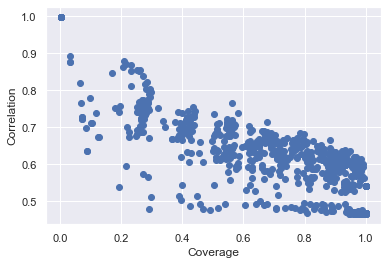

In [4]:
# Plot all model-data combination as corr vs coverage
plt.scatter(raw['Coverage'],raw['Avg-R'])
plt.ylabel('Correlation')
plt.xlabel('Coverage')
fig_path = os.path.join('Figures','Summary','All_Corr_Cov.png')
if SAVE_FIGS: plt.savefig(fig_path)
plt.show()

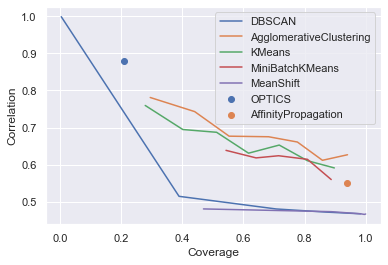

In [5]:
# Plot effect of model parameter as corr vs coverage
data = raw[raw['Data'] == 'Daily']

AgglomerativeClustering = data[data['Base_model'] == 'AgglomerativeClustering'][['Coverage','Avg-R']]
DBSCAN                  = data[data['Base_model'] == 'DBSCAN'][['Coverage','Avg-R']]
KMeans                  = data[data['Base_model'] == 'KMeans'][['Coverage','Avg-R']]
AffinityPropagation     = data[data['Base_model'] == 'AffinityPropagation'][['Coverage','Avg-R']]
MiniBatchKMeans         = data[data['Base_model'] == 'MiniBatchKMeans'][['Coverage','Avg-R']]
OPTICS                  = data[data['Base_model'] == 'OPTICS'][['Coverage','Avg-R']]
MeanShift               = data[data['Base_model'] == 'MeanShift'][['Coverage','Avg-R']]

plt.plot(DBSCAN['Coverage'],DBSCAN['Avg-R'])
plt.plot(AgglomerativeClustering['Coverage'],AgglomerativeClustering['Avg-R'])
plt.plot(KMeans['Coverage'],KMeans['Avg-R'])
plt.plot(MiniBatchKMeans['Coverage'],MiniBatchKMeans['Avg-R'])
plt.plot(MeanShift['Coverage'],MeanShift['Avg-R'])
plt.scatter(OPTICS['Coverage'],OPTICS['Avg-R'])
plt.scatter(AffinityPropagation['Coverage'],AffinityPropagation['Avg-R'])



plt.legend([
            'DBSCAN',
            'AgglomerativeClustering',
            'KMeans',
            'MiniBatchKMeans',
            'MeanShift',
            'OPTICS',
            'AffinityPropagation',
            ]
          )
plt.ylabel('Correlation')
plt.xlabel('Coverage')

fig_path = os.path.join('Figures','Summary','Model_Corr_Cov.png')
if SAVE_FIGS: plt.savefig(fig_path)
plt.show()

# Model Analysis

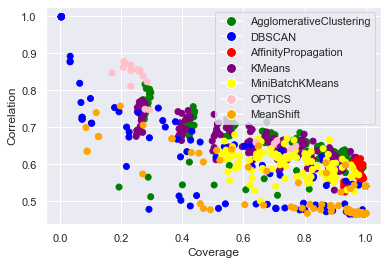

In [6]:
# Plot all combination according to base model
colors = {
            'AgglomerativeClustering':'green',
            'DBSCAN':'blue',
            'AffinityPropagation':'red',
            'KMeans':'purple',
            'MiniBatchKMeans':'yellow',
            'OPTICS':'pink',
            'MeanShift':'orange',
            
         }

legend_elements = [ Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor=color, markersize=10) for color in colors.values() ]
        
plt.scatter(raw['Coverage'],raw['Avg-R'], c=[colors[model] for model in raw['Base_model']])
plt.ylabel('Correlation')
plt.xlabel('Coverage')
plt.legend(legend_elements,colors.keys())
fig_path = os.path.join('Figures','Summary','All_models_Corr_Cov.png')
if SAVE_FIGS: plt.savefig(fig_path)
plt.show()

# Data Analysis - Best Correlation Per Data Set

In [7]:
# get best model for each data set
maxs = raw[raw['Coverage'] > .5][['Data','Avg-R']]
maxs = maxs.groupby('Data').agg('max')
bests = pd.merge(raw,maxs,on=['Avg-R','Data'])
bests = bests.sort_values('Avg-R', ascending = False)[['Avg-R','Coverage','Data','Model']]
bests.head(5)

,Avg-R,Coverage,Data,Model
25,0.764833,0.562241,Daily+Weekly+Monthly+GICS_Sub,OPTICS_1_0
24,0.738057,0.582988,Daily+Weekly+GICS_Sub,OPTICS_1_0
20,0.735088,0.504098,Daily+Monthly,KMeans_300
8,0.722714,0.545643,Daily+Weekly+GICS_Sector,AgglomerativeClustering_300
1,0.715074,0.676230,Daily+Weekly,AgglomerativeClustering_250


# Load all clusters from all combinations

In [8]:
# load all clusters
all_clusters = pd.DataFrame(columns=['Corr','Cluster'])
correlation_path =  os.path.join('Output','Correlations')
cluster_path =  os.path.join('Output','Clusters')

for subdir, dirs, files in os.walk(correlation_path):
    for file in files:

        # for all files open both correlation and cluster, create and stack df
        with open(os.path.join(correlation_path,file), 'r') as fp:
            correlations = json.load(fp)
        with open(os.path.join(cluster_path,file), 'r') as fp:
            clusters = json.load(fp)

        clusters_df = pd.DataFrame.from_dict(correlations, orient='index')
        clusters_df = clusters_df.reset_index().rename(columns= {'index':'key',0:'Corr'})
        clusters_df['Cluster'] = clusters_df.apply(lambda x: clusters[x['key']],axis=1)
        clusters_df['Cluster_len'] = clusters_df.apply(lambda x: len(x['Cluster']), axis = 1)
        clusters_df['File'] = file
        clusters_df = clusters_df.drop('key', axis = 1)
        all_clusters = all_clusters.append(clusters_df)

all_clusters.head(5)
    

,Corr,Cluster,Cluster_len,File
0,0.366488,"[A, ABBV, ABC, ABT, ALGN, ALXN, AMGN, BAX, BDX...",36.0,AffinityPropagation_Daily+GICS_Sector.json
1,0.406569,"[AFL, AIZ, AJG, ALL, AON, CBOE, CINF, CME, HIG...",21.0,AffinityPropagation_Daily+GICS_Sector.json
2,0.481137,"[ANTM, CI, CNC, HUM, UNH]",5.0,AffinityPropagation_Daily+GICS_Sector.json
3,0.413636,"[ADSK, AKAM, APH, CDW, CSCO, FFIV, GLW, HPE, H...",20.0,AffinityPropagation_Daily+GICS_Sector.json
4,0.788827,"[AIG, AMP, AXP, BAC, BEN, BK, BLK, C, CFG, CMA...",43.0,AffinityPropagation_Daily+GICS_Sector.json


# Notable clusters

In [9]:
# Get highly correlated cluster from all models and data
notable_clusters = all_clusters[all_clusters.Cluster_len > 3]
notable_clusters = notable_clusters[notable_clusters.Corr > .95]
notable_clusters.head(5)

,Corr,Cluster,Cluster_len,File
6,0.970481,"[ALK, DAL, LUV, UAL]",4.0,AffinityPropagation_Daily+Monthly.json
6,0.970481,"[ALK, DAL, LUV, UAL]",4.0,AffinityPropagation_Daily.json
19,0.968737,"[CCL, MGM, NCLH, RCL]",4.0,AffinityPropagation_Weekly+GICS_Sector.json
21,0.968737,"[CCL, MGM, NCLH, RCL]",4.0,AffinityPropagation_Weekly+Monthly+GICS_Sector...
16,0.968737,"[CCL, MGM, NCLH, RCL]",4.0,AffinityPropagation_Weekly+Monthly.json


In [10]:
# [ALK, DAL, LUV, UAL]	all airlines - with out using GICS
# [CCL, MGM, NCLH, RCL] cruises and resorts

# Best Model-Data Analysis

In [11]:
# Get top cluster for top Model-Data combo
notable_clusters = all_clusters[all_clusters['File'] == 'AgglomerativeClustering_250_Daily+Weekly.json']
notable_clusters = notable_clusters[notable_clusters.Corr > .95]
notable_clusters = notable_clusters[notable_clusters.Cluster_len >= 3] # for nice visualizations
notable_clusters.head(5)

,Corr,Cluster,Cluster_len,File
21,0.967270,"[CFG, CMA, FITB, HBAN, KEY, RF, ZION]",7.0,AgglomerativeClustering_250_Daily+Weekly.json
27,0.950646,"[AAPL, ADBE, CRM, MSFT, PYPL]",5.0,AgglomerativeClustering_250_Daily+Weekly.json
35,0.971163,"[AMAT, KLAC, LRCX]",3.0,AgglomerativeClustering_250_Daily+Weekly.json
56,0.967906,"[DHI, LEN, PHM]",3.0,AgglomerativeClustering_250_Daily+Weekly.json
82,0.981003,"[CAT, CMI, DE, PCAR]",4.0,AgglomerativeClustering_250_Daily+Weekly.json


In [12]:
# Get time series data for clusters
ClustersVis = list(notable_clusters['Cluster'])
start = datetime(2019,11,1)
end = datetime(2020,8,1)
results = [yf.download(ClusterVis, start= start, end= end ,interval = '1d',prepost = True,threads = False)['Close'] for ClusterVis in ClustersVis]

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  4 of 4 completed


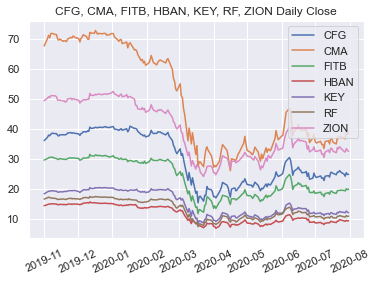

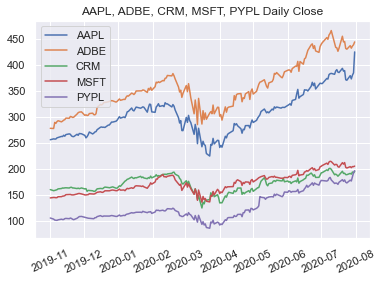

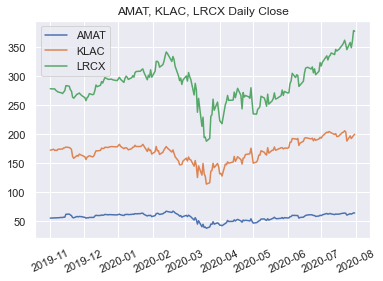

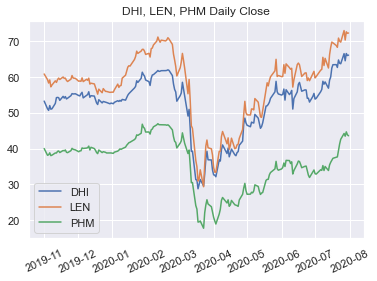

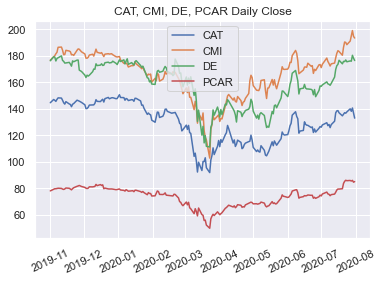

In [13]:
# Print Clusters time series data
Top_Model_path = os.path.join('Figures','Top_Model')

for result in results:
    plt.title(', '.join(result.columns) + ' Daily Close')    
    plt.plot(result)
    plt.xticks(rotation=25)
    plt.legend(result.columns)
    if SAVE_FIGS: plt.savefig(os.path.join(Top_Model_path,'_'.join(result.columns) + '_DailyClose.png'))
    plt.show()

In [14]:
# view GISC of clusters
GICS = pd.read_csv(os.path.join('Data','GICS-wiki.csv'),encoding='ISO-8859-1').set_index('Stock', drop =True)
for result in results:
    print(GICS[GICS.index.isin(result.columns)][['GICS Sector','GICS Sub Industry']])

GICS Sector  GICS Sub Industry
Stock                               
CFG    Financials     Regional Banks
CMA    Financials  Diversified Banks
FITB   Financials     Regional Banks
HBAN   Financials     Regional Banks
KEY    Financials     Regional Banks
RF     Financials     Regional Banks
ZION   Financials     Regional Banks
                  GICS Sector                           GICS Sub Industry
Stock                                                                    
ADBE   Information Technology                        Application Software
AAPL   Information Technology  Technology Hardware, Storage & Peripherals
MSFT   Information Technology                            Systems Software
PYPL   Information Technology       Data Processing & Outsourced Services
CRM    Information Technology                        Application Software
                  GICS Sector        GICS Sub Industry
Stock                                                 
AMAT   Information Technology  Semiconductor 